In [1]:
import numpy
from etrade.spot.trader import Station
from etrade.spot.market.recycle import BasicRecycle, PointwiseRecycle
from etrade.spot.forecast.market import DistributiveSeries, DistributiveMarket
from etrade.spot.forecast.plan_a.constructor import *
from etrade.spot.forecast.plan_a.transformer import MarketSampleTransformer, MarketSampleDataset, TabTransformer
from etrade.spot.forecast.plan_a.simulator4 import PredictBasedMarketSimulator

from  data_utils.stochastic_utils.vdistributions.abstract import AbstractDistribution
from  data_utils.stochastic_utils.vdistributions.parameter.continuous.basic import NormalDistribution, SkewNormalDistribution
from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.kernel2 import KernelMixDistribution
from data_utils.stochastic_utils.vdistributions.parameter.continuous.kernel.gaussian2 import WeightedGaussianKernelMixDistribution
from data_utils.stochastic_utils.vdistributions.tools.divergence import kl_divergence_continuous, crps, quantile_RMSE

from data_utils.stochastic_utils.vdistributions.nonparametric.continuous.mfk.skewnd2 import dof_snd_fitter

from scipy.optimize import differential_evolution

In [2]:
market_len = 4
init_kwargs = {
    "aq_constructor": OrdinaryGaussianKernelDistributionConstructor((0, 50), (1, 10), (1, 2)),
    "dp_constructor": OrdinaryGaussianKernelDistributionConstructor((0, 10), (1, 2), (1, 2)),
    "rp_constructor": OrdinaryGaussianKernelDistributionConstructor((0, 20), (1, 4), (1, 2)),
    "aq_range": (0, 50),
    "dp_range": (0, 1e+6),
    "rp_range": (0, 1e+6),
    "predict_weight": numpy.full((3, market_len), 1),
    "noise_weight_range": ((0.01, 0.05), (0.01, 0.05), (0.01, 0.05)),
    "market_len": market_len
}

station = Station("station", 50)
br = BasicRecycle(0.5, 1.05)
simulator = PredictBasedMarketSimulator(**init_kwargs)

In [3]:
aq, dp, rp = simulator.predicted_random(1000)

[23.737112351350405, 48.42481106702746, 7.2206677871354605, 33.42151054182231]
[0.0, 50.0, 50.0, 0.0]
1.1280410174733564


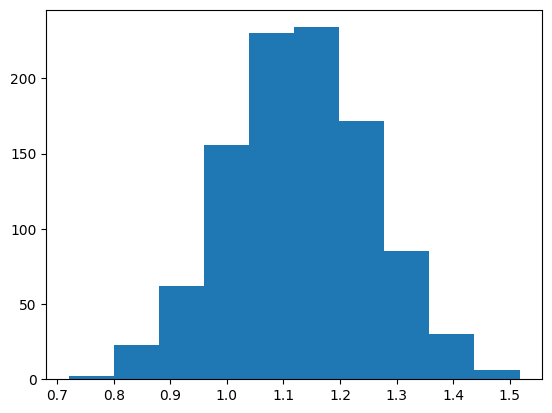

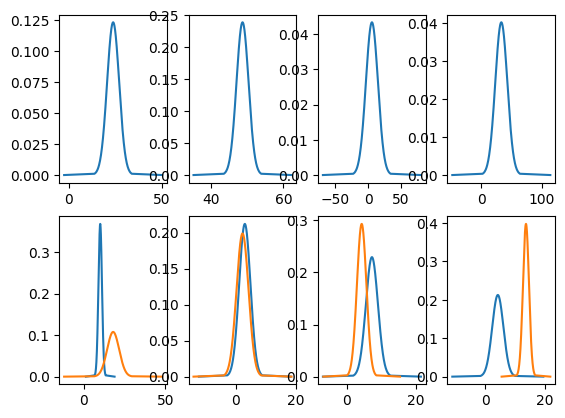

In [4]:
x = simulator.random_sample_optimize(station, br, aq, dp, rp)
print(numpy.mean(aq, axis=1).tolist())
print(x.tolist())

print(
    numpy.sum(numpy.mean(aq, axis=1)) / numpy.sum(x)
)

pyplot.hist(numpy.sum(aq, axis=0) / numpy.sum(x))
pyplot.show()

simulator.predict_market.plot2(1, 1000)

C:\Users\sangsiyuan\AppData\Roaming\Python\Python312\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


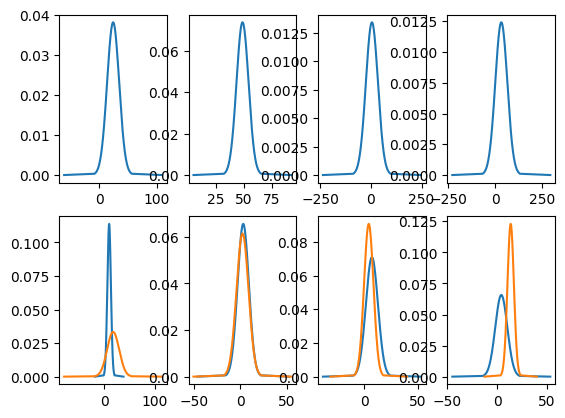

In [5]:
real_market = simulator.new_divergenced_market(js_divergence=(0.2,0.2,0.2))
real_market.plot2(1, 1000)

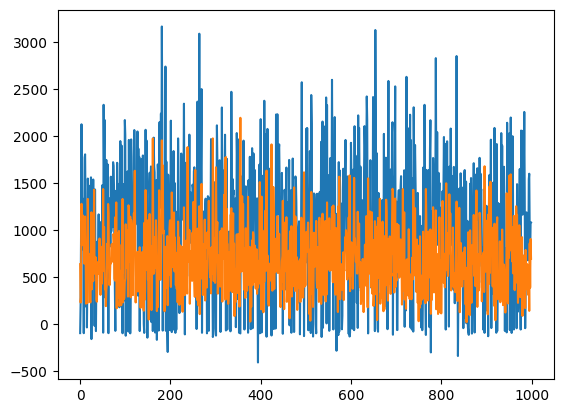

In [6]:
real_aq, real_dp, real_rp = real_market.rvf(1000, simulator.aq_range, simulator.dp_range, simulator.rp_range)
pyplot.plot(simulator.random_sample_trade(x, station, br, real_aq, real_dp, real_rp))
pyplot.plot(simulator.random_sample_trade(real_aq, station, br, real_aq, real_dp, real_rp))
pyplot.show()

In [69]:
test_dist = WeightedGaussianKernelMixDistribution([0,1,1],[1,1,2],[20,1,2])

In [70]:
ppf,pdf,_ = test_dist.curves(1000)
ppf

array([[ 2.22044605e-16, -7.92969416e+00],
       [ 1.00100100e-03, -2.59866010e+00],
       [ 2.00200200e-03, -2.35664607e+00],
       ...,
       [ 9.97997998e-01,  2.25755590e+01],
       [ 9.98998999e-01,  2.28071625e+01],
       [ 1.00000000e+00,  2.79807384e+01]])

In [71]:
test_dist.cdf(-3)

0.00028264810305926716

In [72]:
test_dist.std()

9.531002045955084

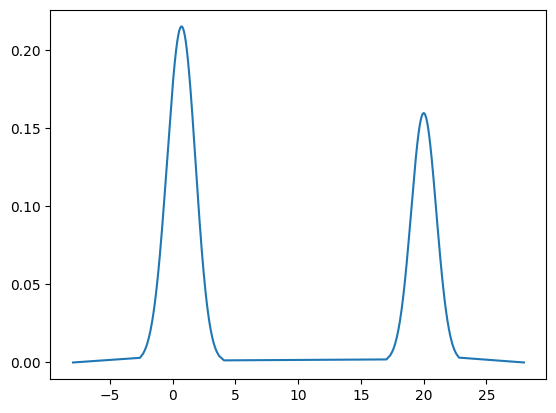

In [73]:
pyplot.plot(pdf[:,0],pdf[:,1])

In [75]:
pdl=OrdinaryGaussianKernelDistributionConstructor((0, 50), (1, 10), (1, 2)).random(10)

In [76]:
odl=OrdinaryGaussianKernelDistributionConstructor((0, 50), (1, 10), (1, 2)).random(10)

In [82]:
ov = numpy.asarray([i.rvf() for i in odl])
ov

array([49.45308357,  3.73653303, 20.94212507, 16.35387014, 38.94150578,
       50.13367683, 42.50884709, 16.95676257, 47.61724421, 35.56924489])

In [83]:
mean_pdl = numpy.asarray([i.mean() for i in pdl])

(array([1., 0., 1., 1., 0., 3., 0., 2., 1., 1.]),
 array([-34.56732793, -28.20634516, -21.8453624 , -15.48437963,
         -9.12339687,  -2.7624141 ,   3.59856866,   9.95955143,
         16.32053419,  22.68151696,  29.04249972]),
 <BarContainer object of 10 artists>)

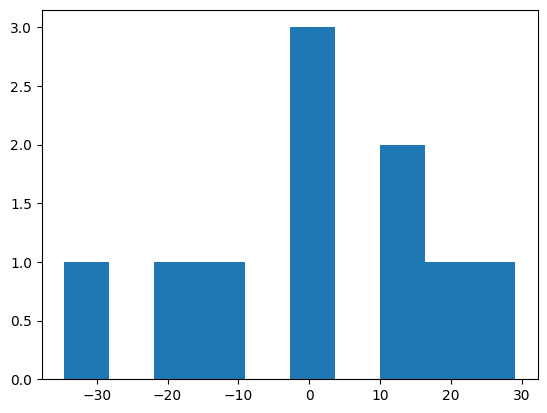

In [85]:
pyplot.hist(mean_pdl - ov)